In [74]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
from scipy.optimize import curve_fit

plt.rcParams['figure.dpi'] = 150

In [75]:
#Data_names = []
#for (dir_path, dir_names, file_names) in os.walk('./Labday_2_measurements_3'):
#    Data_names.extend(file_names)
    

In [76]:
#Data_list = []

#for i, Data_name in enumerate(Data_names):
#    Data = np.loadtxt('Labday_2_measurements_3/' + Data_name, skiprows = 3)
#    Data_list.append(Data)

In [77]:
# List of directories to search for data
directories = ['./Labday_2_measurements_1', './Labday_2_measurements_2', './Labday_2_measurements_3']

Data_list = []

# Loop over each directory
for directory in directories:
    # List files in the directory
    file_names = os.listdir(directory)
    
    # Loop over each file in the directory
    for file_name in file_names:
        # Load data from the file
        Data = np.loadtxt(os.path.join(directory, file_name), skiprows=3)
        
        # Find segments where V2 is increasing
        increasing_segments = []
        start_idx = None
        for idx in range(1, len(Data)):
            if Data[idx, 2] > Data[idx - 1, 2]:  # Check if V2 is increasing
                if start_idx is None:
                    start_idx = idx - 1
            elif start_idx is not None:
                increasing_segments.append(Data[start_idx:idx])
                start_idx = None
        
        # Append increasing segments to Data_list
        Data_list.extend(increasing_segments)


# Now Data_list contains all segments where V2 is increasing


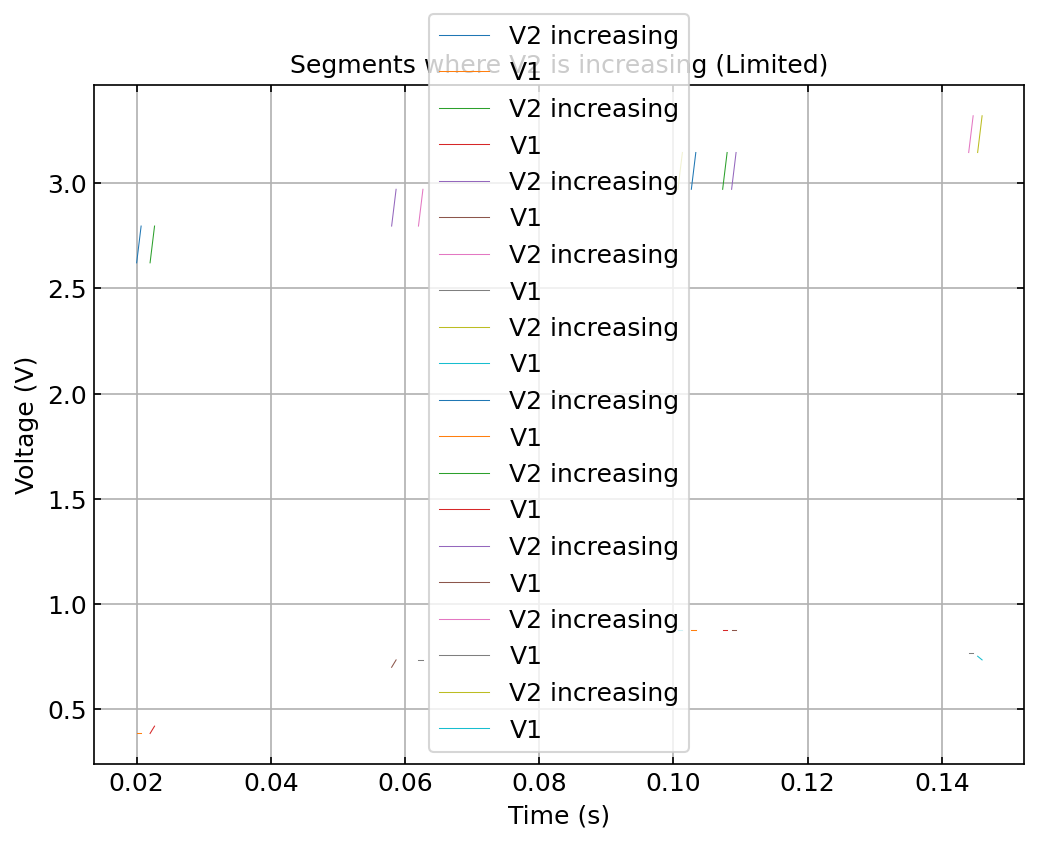

In [78]:
# Plotting a limited number of segments where V2 is increasing
plt.figure(figsize=(8, 6))
num_segments_to_plot = min(10, len(Data_list))  # Change 10 to the desired number of segments to plot
for segment in Data_list[:num_segments_to_plot]:
    time = segment[:, 0]
    V1 = segment[:, 1]
    V2 = segment[:, 2]
    plt.plot(time, V2, label='V2 increasing')
    plt.plot(time, V1, label='V1')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Segments where V2 is increasing (Limited)')
plt.legend()
plt.grid(True)
plt.show()



In [79]:
len(Data_list)

59923

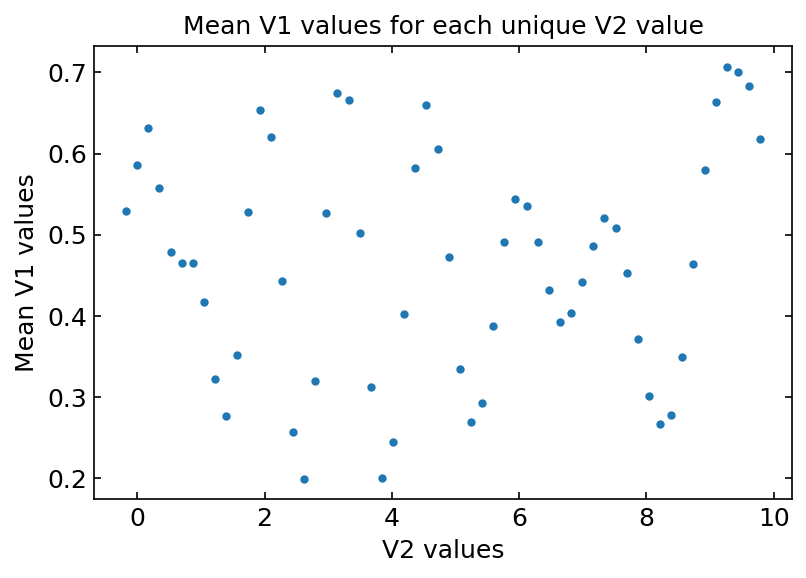

58

In [80]:
c_light = const.c
eps0 = const.epsilon_0
a = (1/4)*c_light*eps0
b = (2*np.pi)/(600e-9) 

a_guess = a*2
k_guess = 2
c_guess = 1

p0_1= [a_guess, k_guess, c_guess]

def Intensity_fit(v,*p): #define fitting function
    a=p[0]
    k = p[1]
    c = p[2]
    return a * (1+np.cos(b*2*k*v))+c
total_data=[]
# Plot the data between the first min and max points for each dataset
for data in Data_list:
    #plt.figure()
    total_data.append(data)

# Initialize empty lists to store V1 and V2 values
V1_values = []
V2_values = []

# Iterate through each array in total_data
for array in total_data:
    # Extract V1 and V2 values from the array and append to the respective lists
    V1_values.extend(array[:, 1])  # Assuming V1 is in the second column
    V2_values.extend(array[:, 2])  # Assuming V2 is in the third column

# Convert the lists to numpy arrays if needed
V1_values = np.array(V1_values)
V2_values = np.array(V2_values)
#plt.plot(V2_values, V1_values, '.')   
    
    #plt.plot(V2_actual, V1_actual,'.',label='V1')
    #plt.plot(time, V2, label='V2')

    #popt, pcov = sp.curve_fit(Intensity_fit, V2, V1, p0=p0_1)
    #plt.plot(V2, Intensity_fit(V2, *popt),'o',label='fit for both')

    #plt.xlabel('Time')
   # plt.ylabel('Value')
    #plt.title('Data between the first min and max points for each dataset')
#plt.legend()
    #plt.show()
    # Find unique V2 values and corresponding indices
unique_V2, indices = np.unique(V2_values, return_inverse=True)

# Initialize an array to store mean V1 values for each unique V2 value
mean_V1_values = np.zeros_like(unique_V2)

# Iterate through unique V2 values
for i, unique_v2 in enumerate(unique_V2):
    # Find indices corresponding to the current unique V2 value
    indices_for_v2 = np.where(indices == i)[0]
    # Extract V1 values corresponding to the current unique V2 value
    V1_for_v2 = V1_values[indices_for_v2]
    # Calculate the mean of V1 values for the current unique V2 value
    mean_V1_values[i] = np.mean(V1_for_v2)

# Plot the mean V1 values against unique V2 values
plt.plot(unique_V2, mean_V1_values, '.')
plt.xlabel('V2 values')
plt.ylabel('Mean V1 values')
plt.title('Mean V1 values for each unique V2 value')
plt.show()
len(unique_V2)

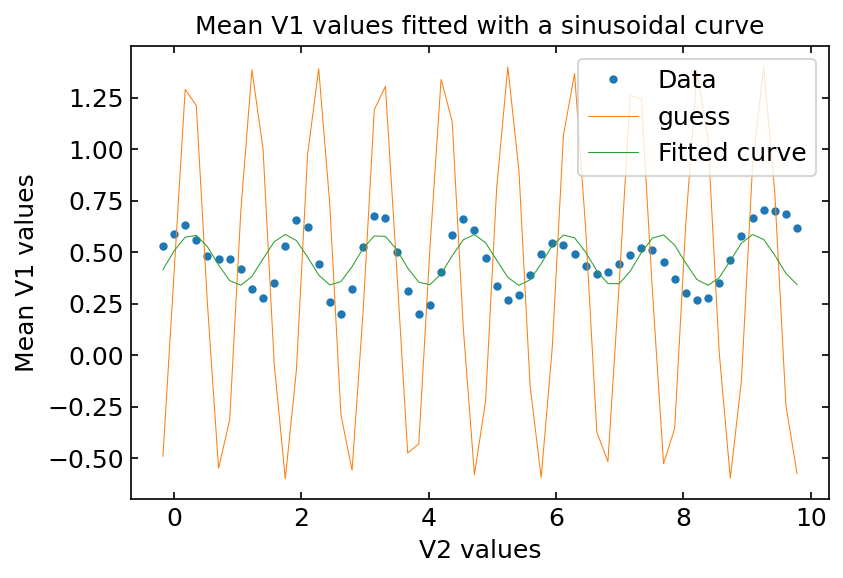

Optimal values:
Amplitude: 0.12376405634470766 +/- 0.02082586339218405
Frequency: 0.6796342612478262 +/- 0.00902595951386282
Phase: 6.641514818283613 +/- 0.315408877712676
Offset: 0.46238164828940836 +/- 0.014720154340593577


In [88]:
def Sinusoidal_fit(v, *p): 
    amplitude = p[0]
    frequency = p[1]
    phase = p[2]
    offset = p[3]
    return amplitude * np.sin(2 * np.pi * frequency * v + phase) + offset
# Initial guess for fitting parameters
amplitude_guess = 1.0
frequency_guess = 1.0
phase_guess = 0.0
offset_guess = 0.4
p0 = [amplitude_guess, frequency_guess, phase_guess, offset_guess]

# Perform curve fitting
popt, pcov = sp.curve_fit(Sinusoidal_fit, unique_V2, mean_V1_values, p0=p0)

# Calculate the standard deviations of the fitted parameters
perr = np.sqrt(np.diag(pcov))

# Plot the fitted curve
plt.plot(unique_V2, mean_V1_values, '.', label='Data')
plt.plot(unique_V2, Sinusoidal_fit(unique_V2, *p0), label = 'guess')
plt.plot(unique_V2, Sinusoidal_fit(unique_V2, *popt), label='Fitted curve')
plt.xlabel('V2 values')
plt.ylabel('Mean V1 values')
plt.title('Mean V1 values fitted with a sinusoidal curve')
plt.legend()
plt.show()

# Print the fitted parameters with uncertainties
print("Optimal values:")
print("Amplitude:", popt[0], "+/-", perr[0])
print("Frequency:", popt[1], "+/-", perr[1])
print("Phase:", popt[2], "+/-", perr[2])
print("Offset:", popt[3], "+/-", perr[3])


Importing data
Data succesfully imported


/tmp/ipykernel_26509/1729433283.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


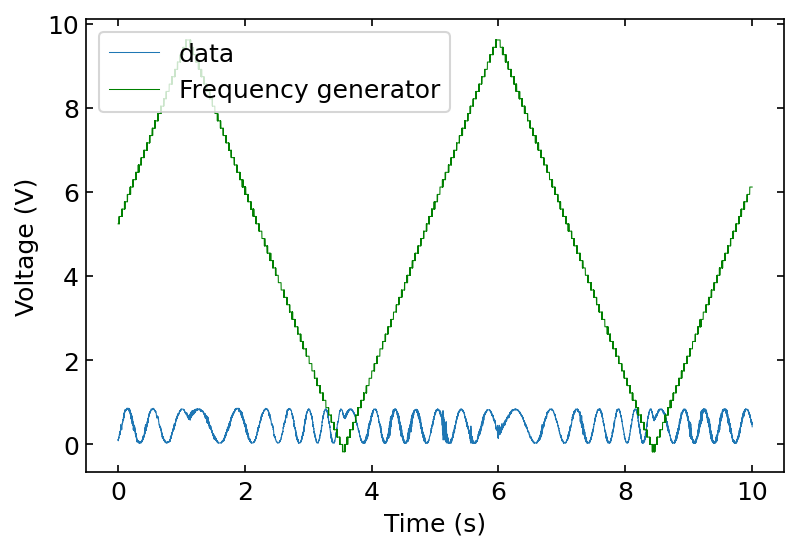

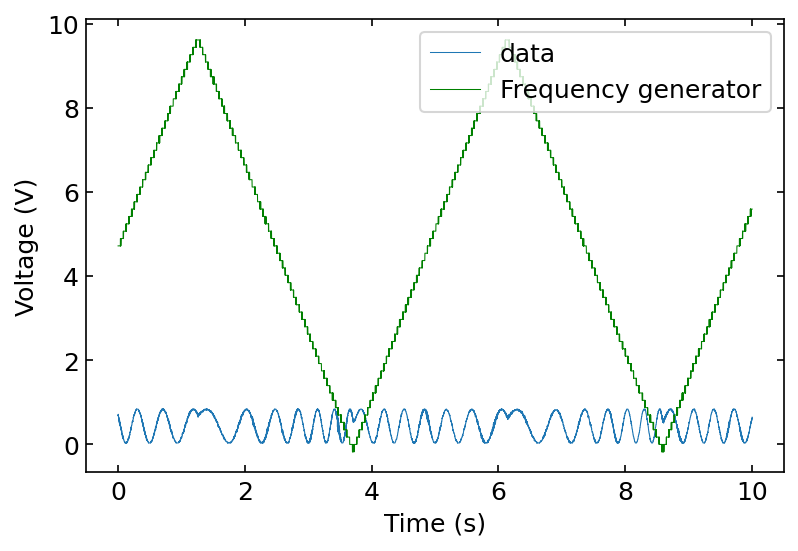

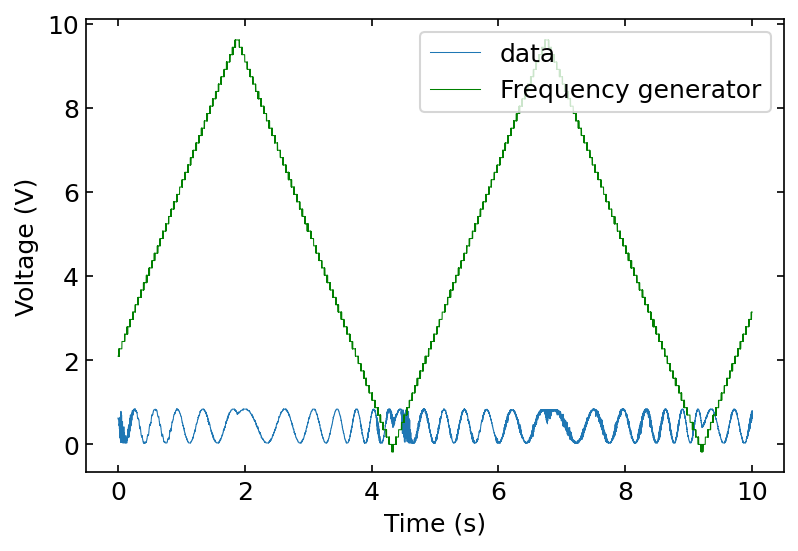

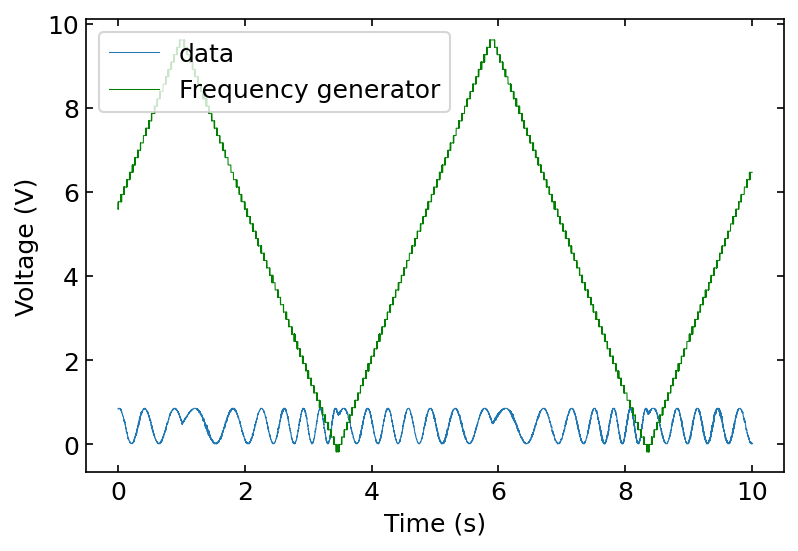

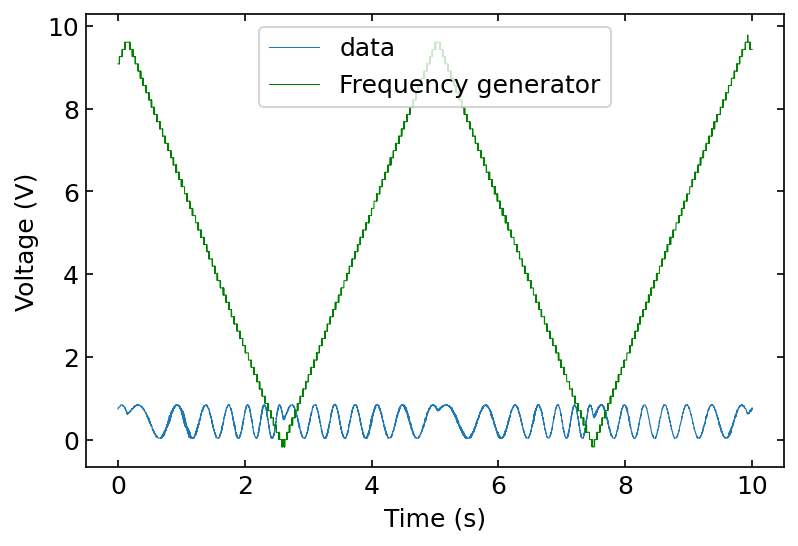

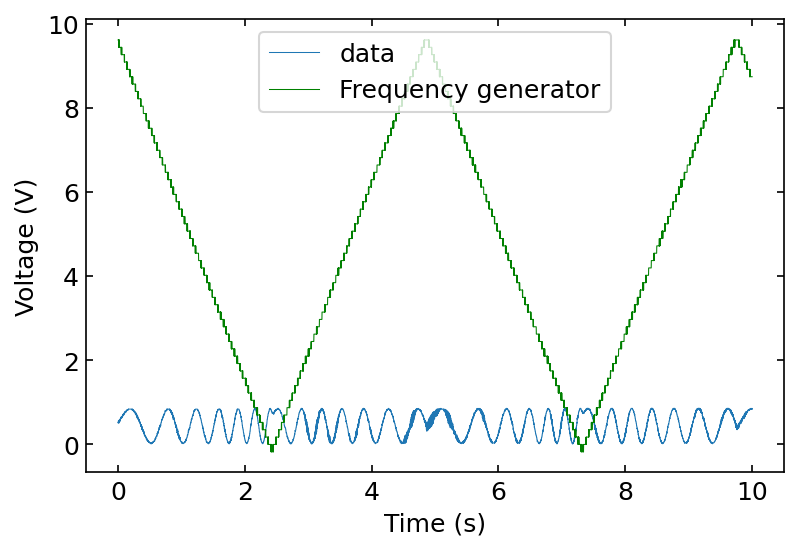

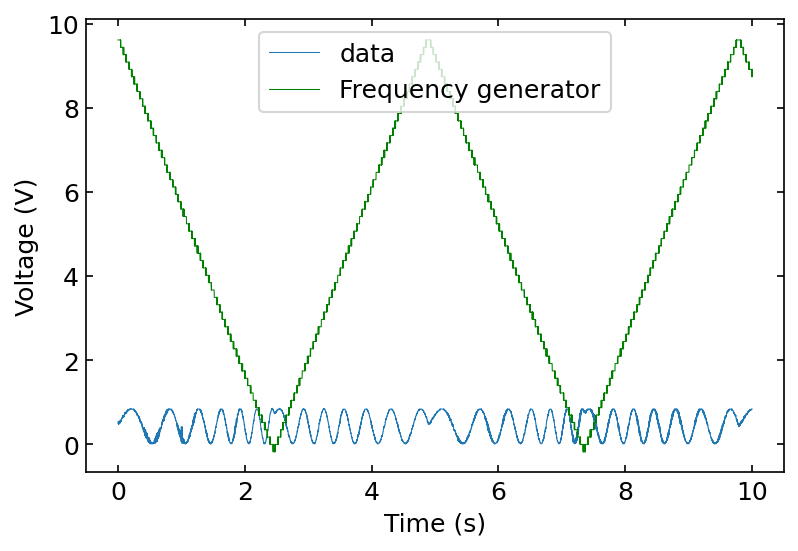

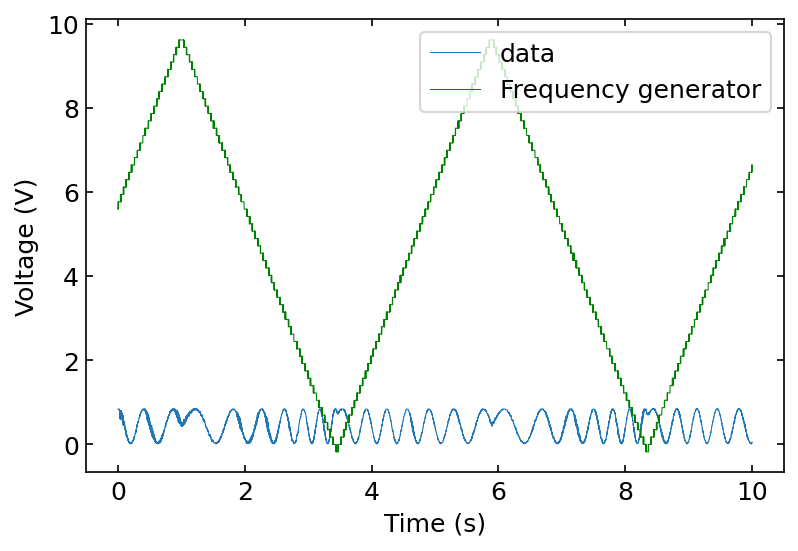

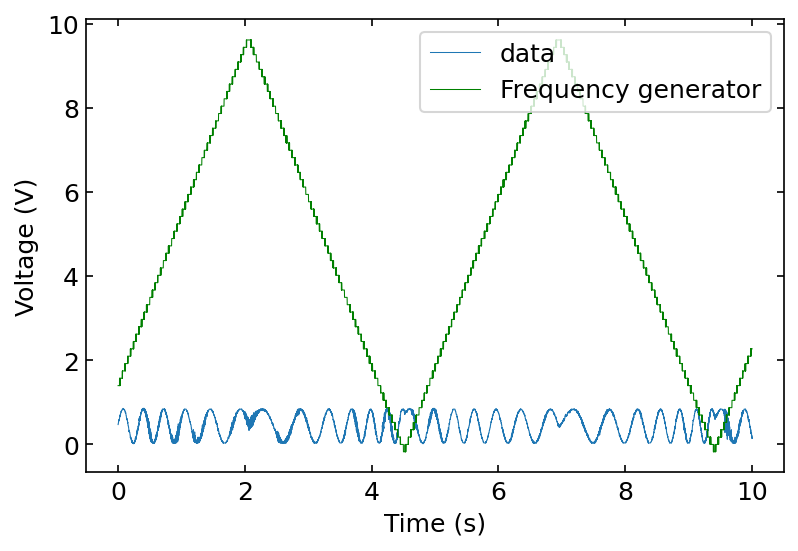

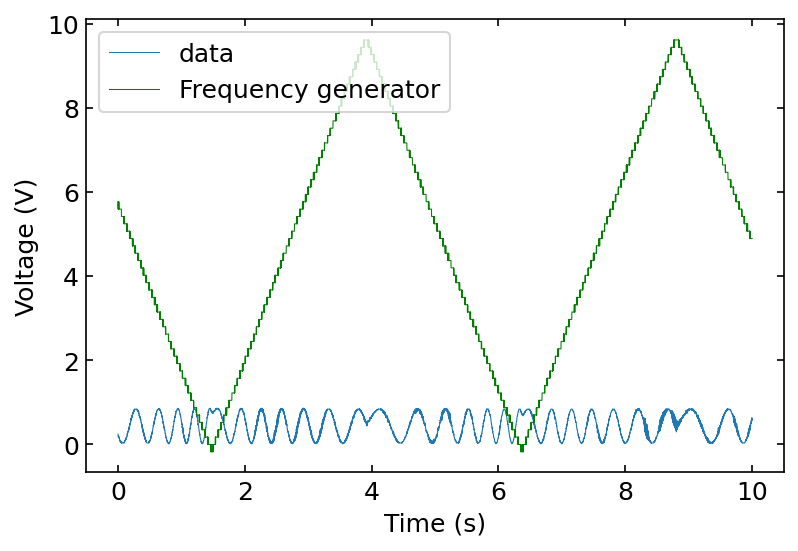

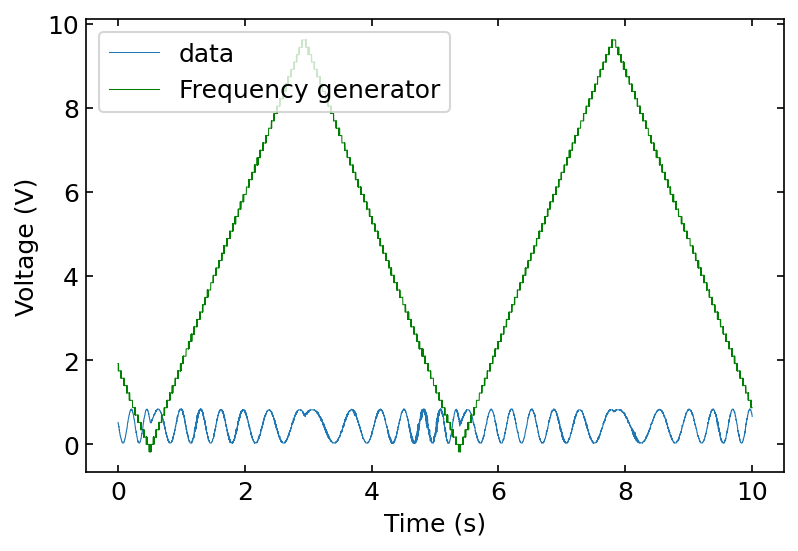

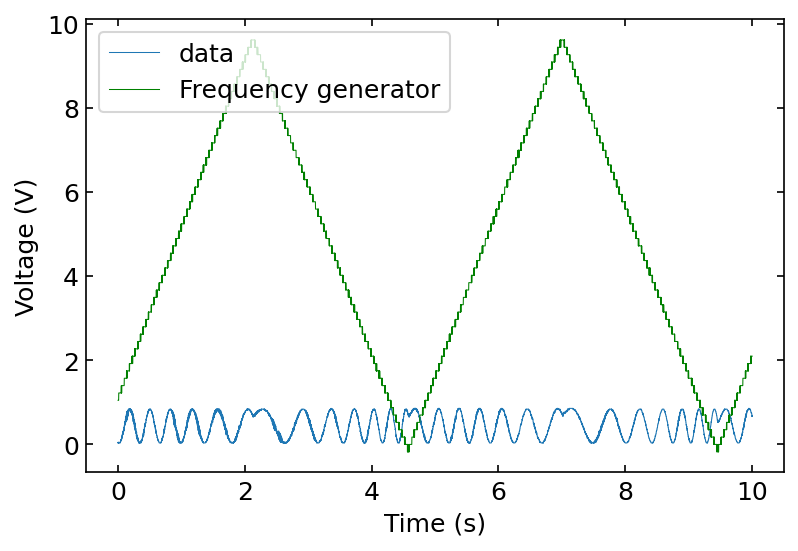

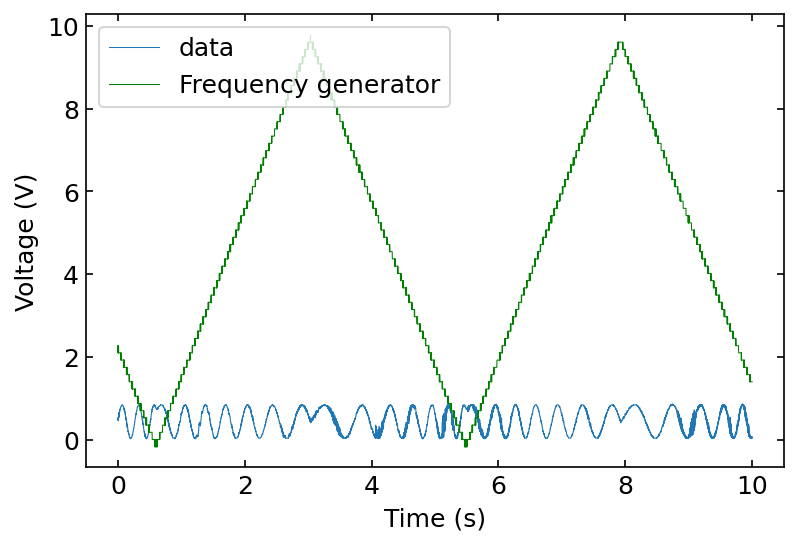

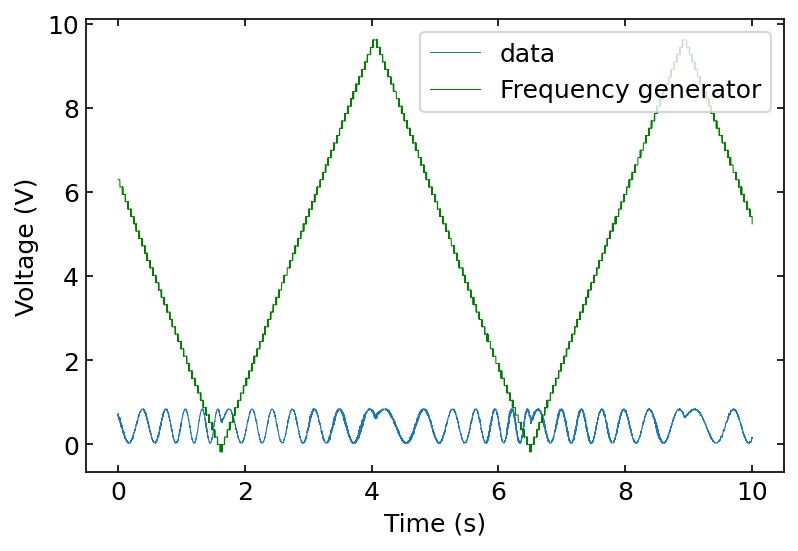

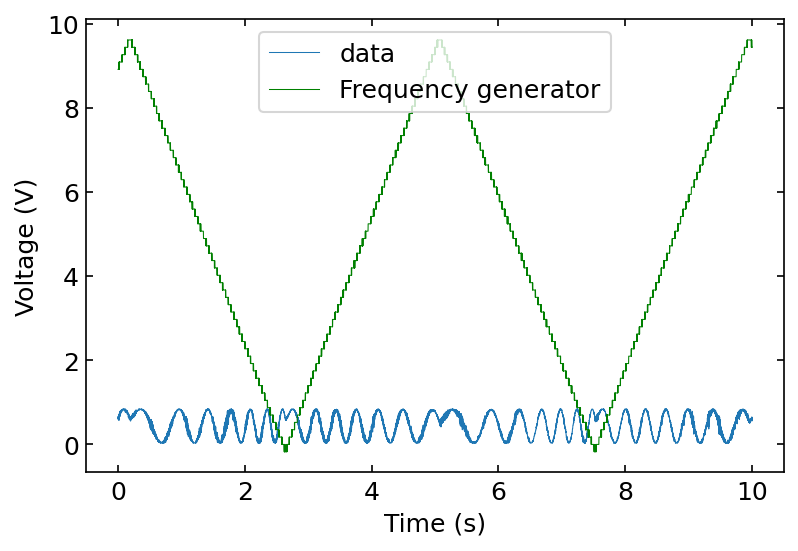

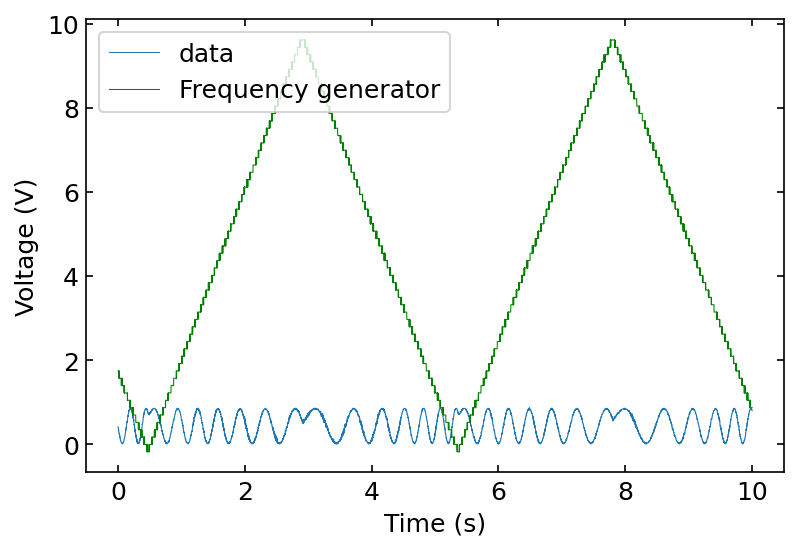

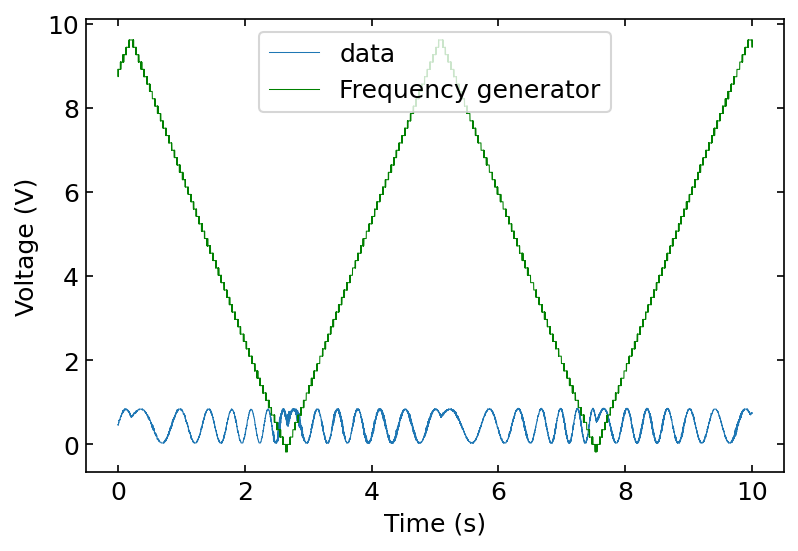

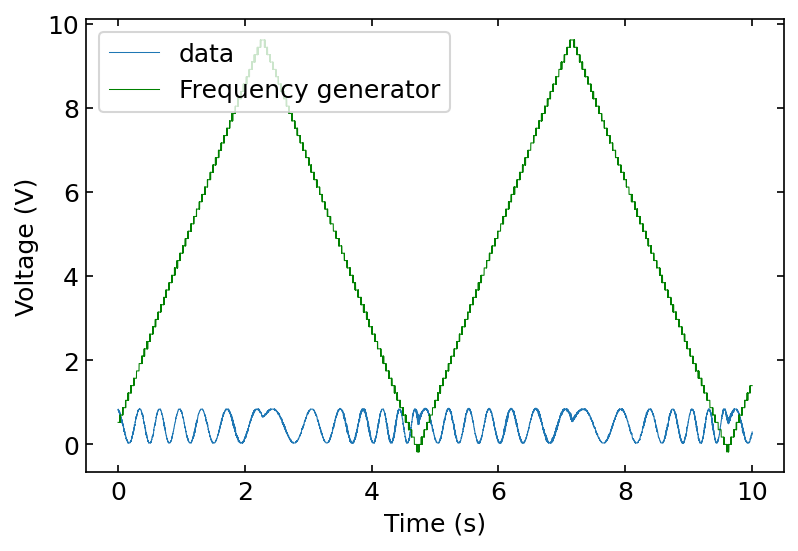

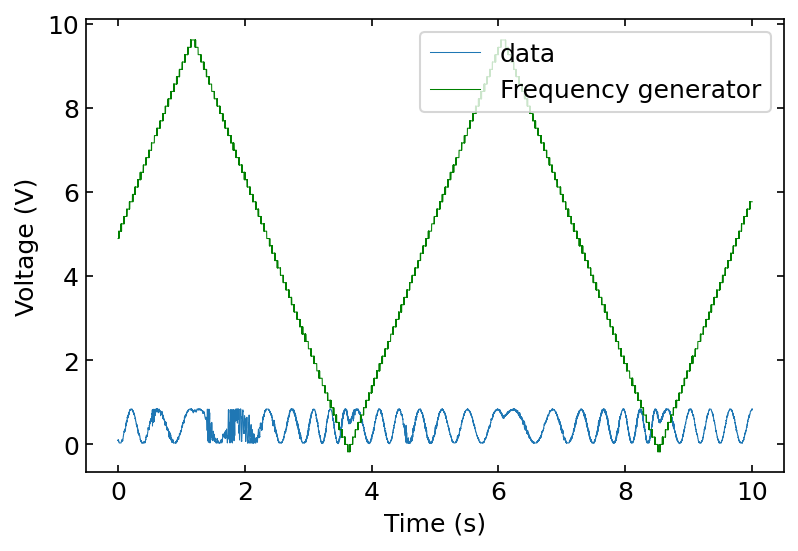

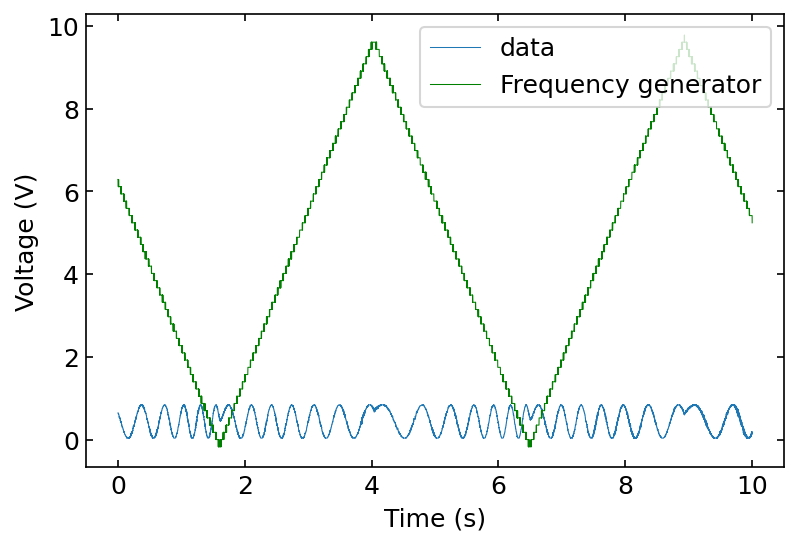

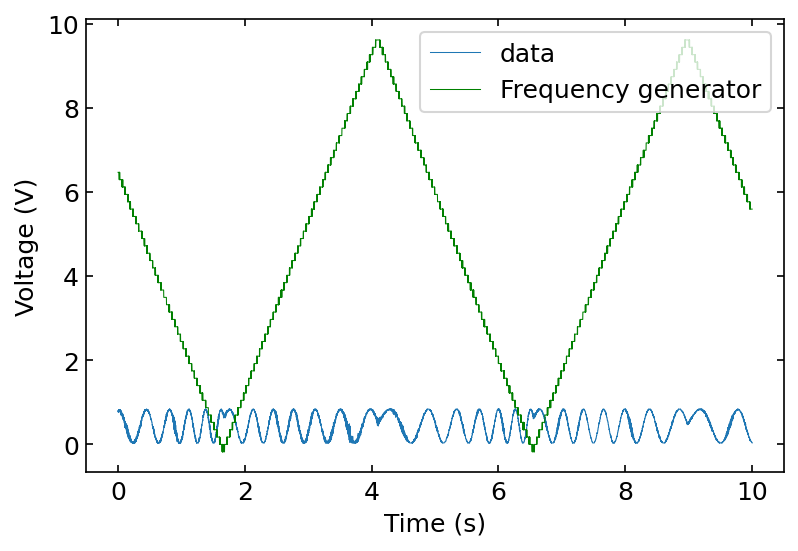

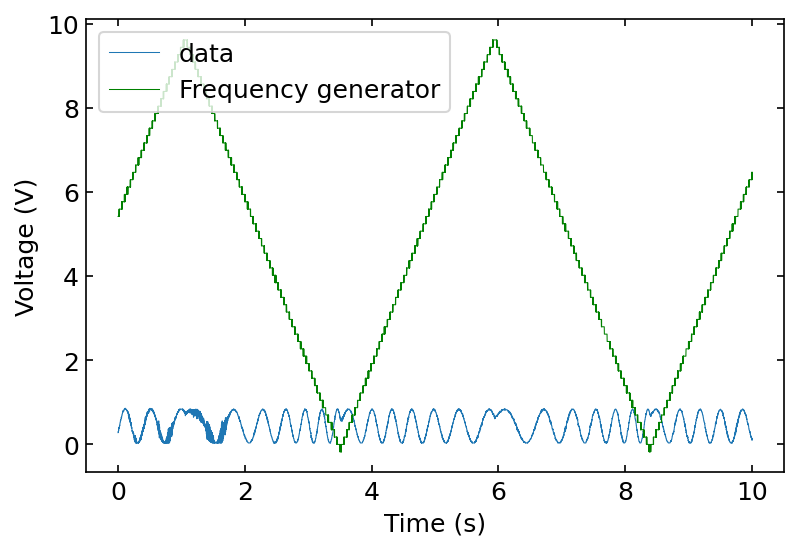

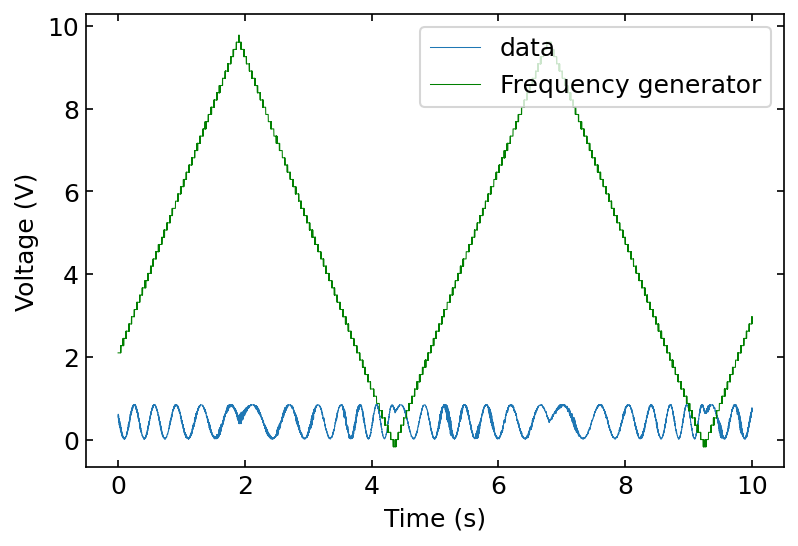

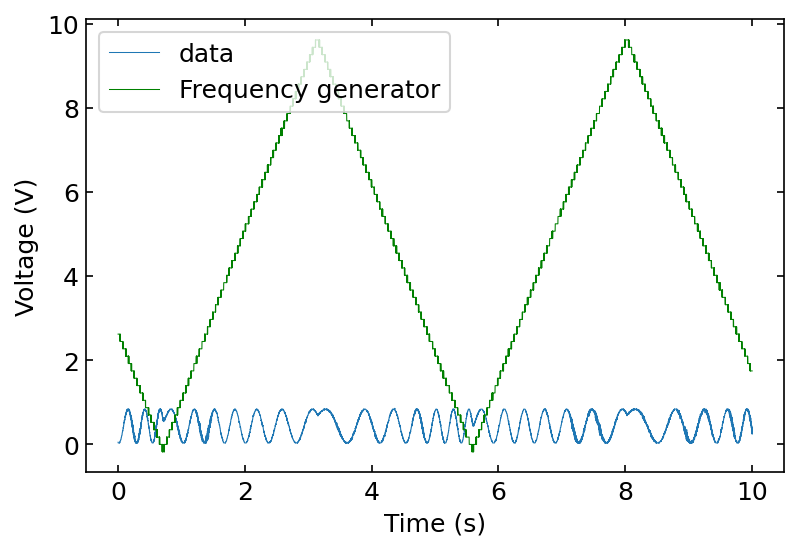

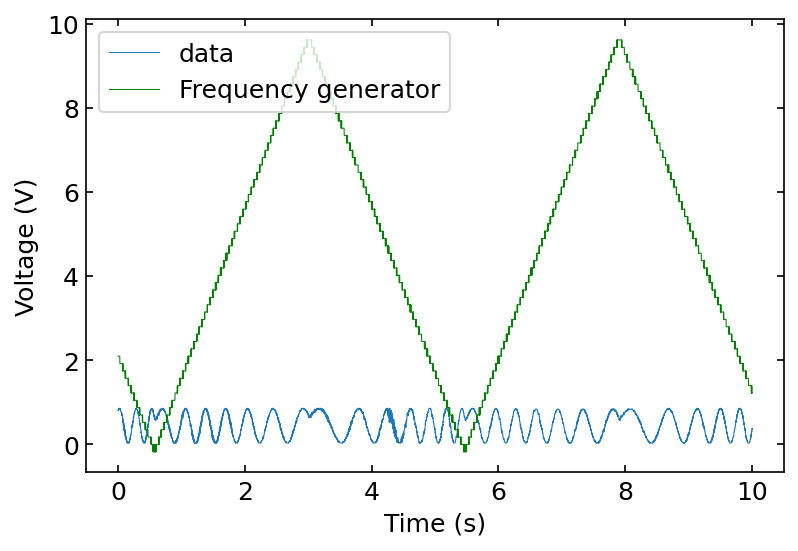

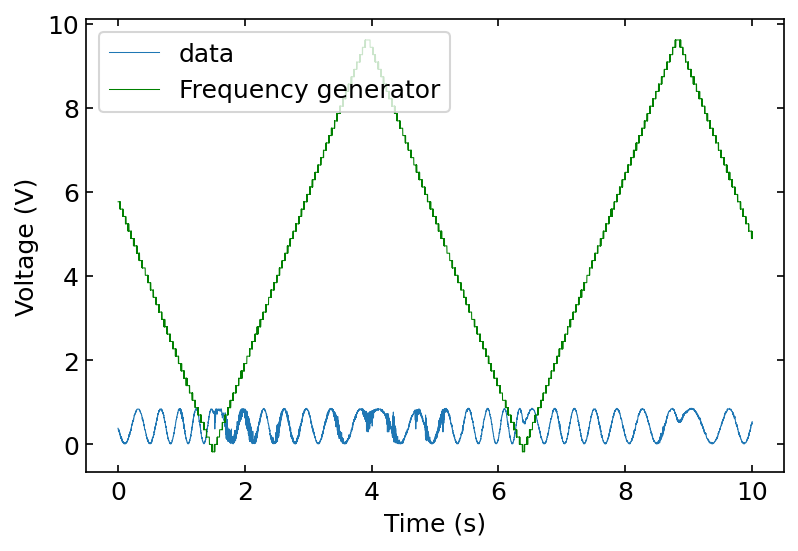

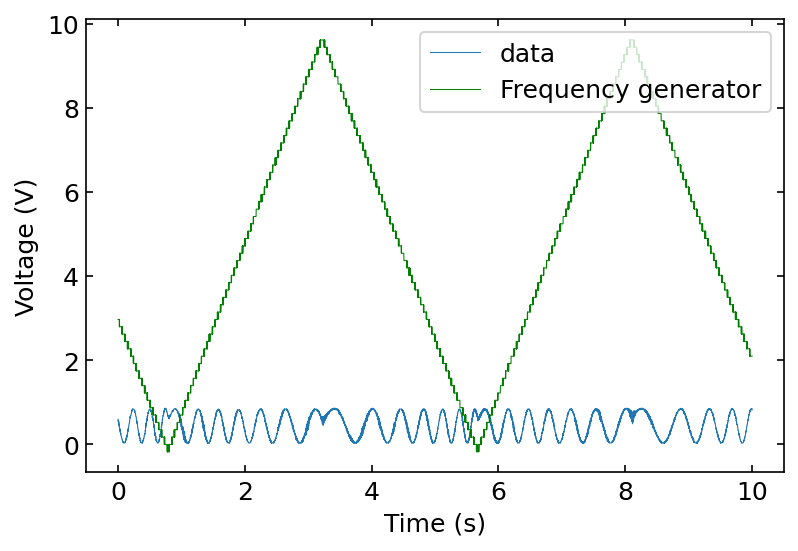

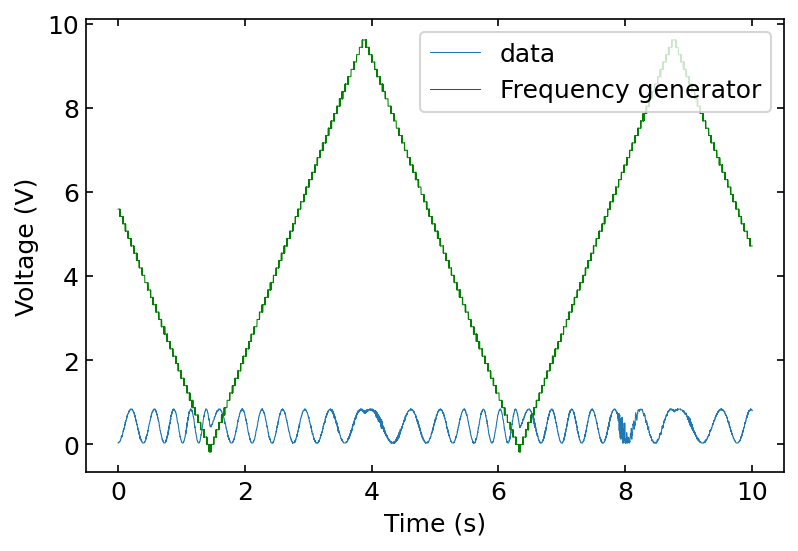

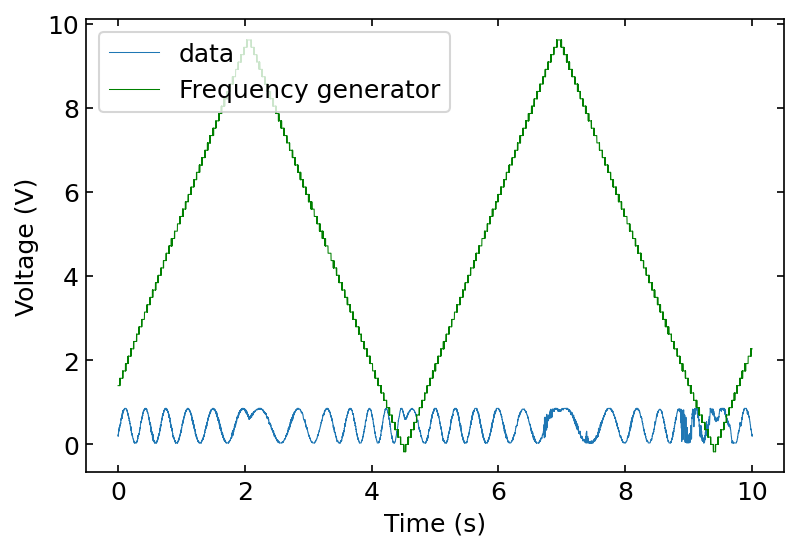

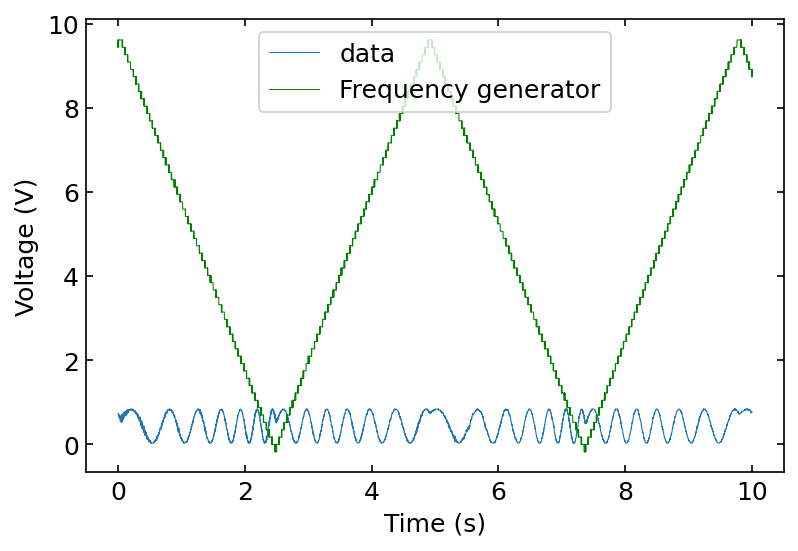

Fitting begins


/tmp/ipykernel_26509/1729433283.py:162: RuntimeWarning: invalid value encountered in sqrt
  ps_cov2[j].append(np.sqrt(p_cov[j][j]))
/tmp/ipykernel_26509/1729433283.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/tmp/ipykernel_26509/1729433283.py:162: RuntimeWarning: invalid value encountered in sqrt
  ps_cov2[j].append(np.sqrt(p_cov[j][j]))


Fitting was succesfull


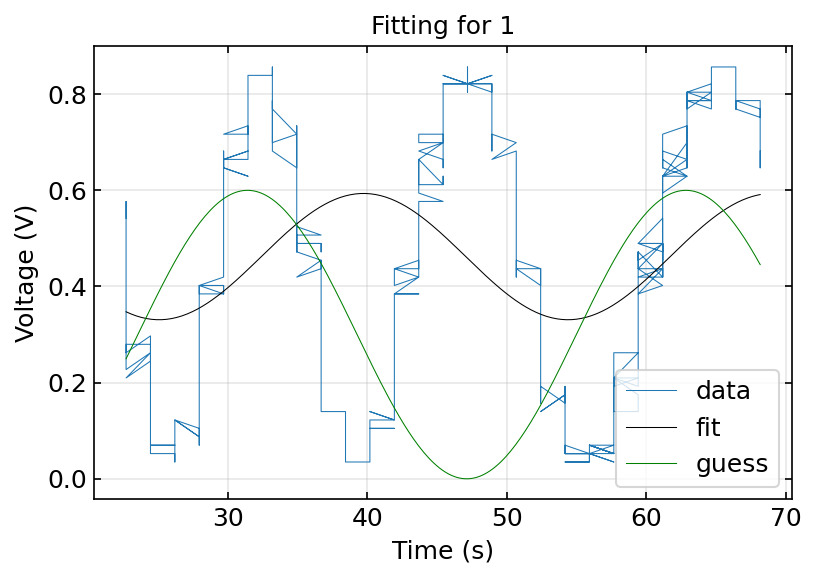

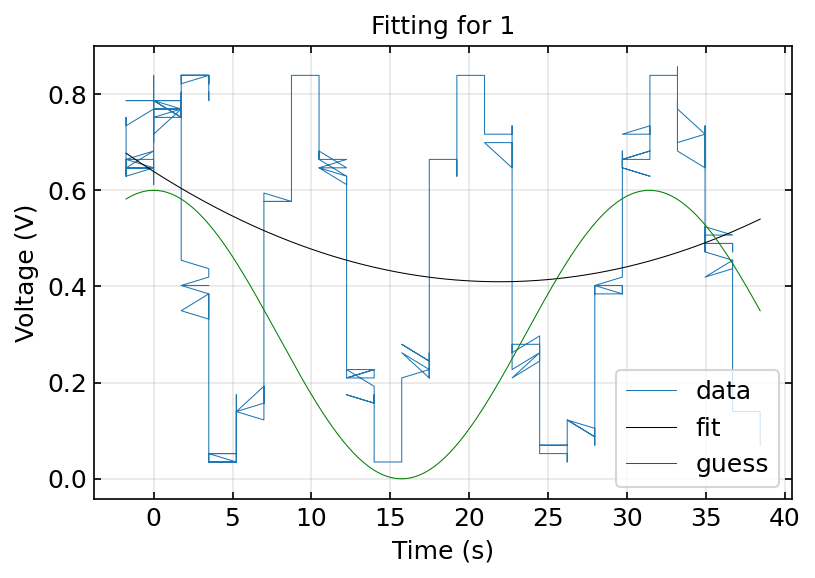

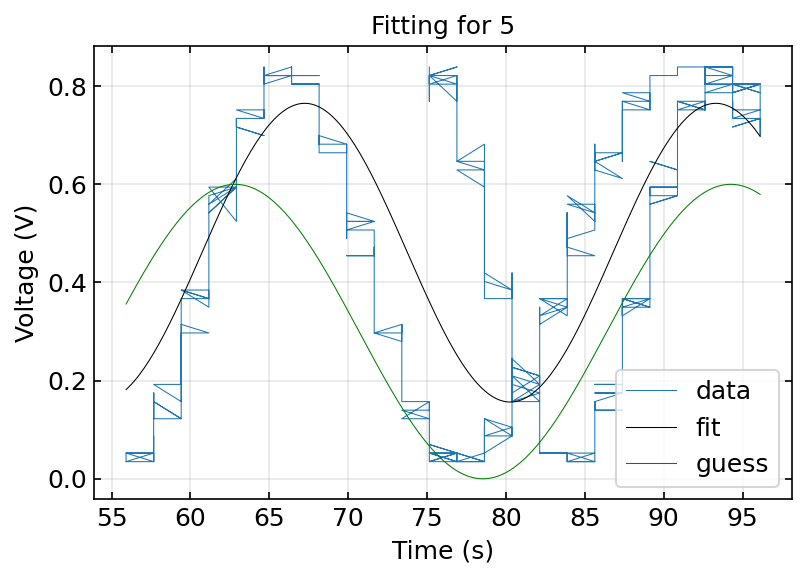

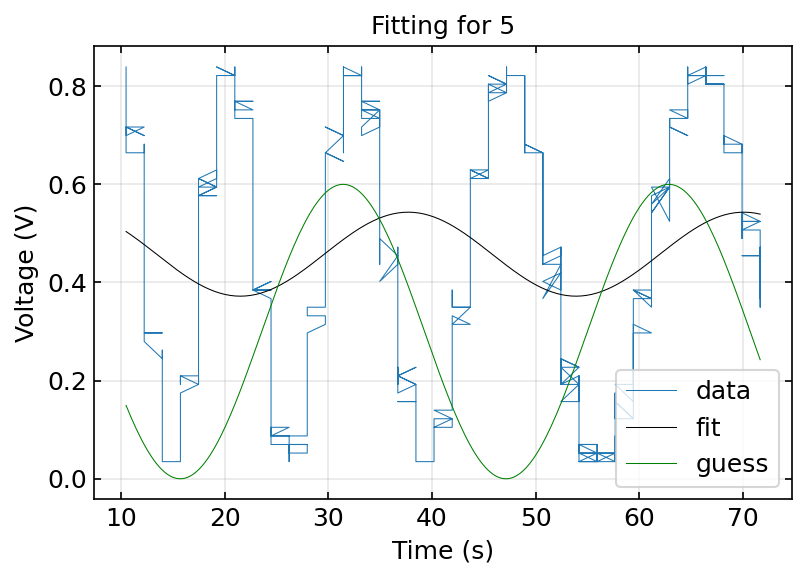

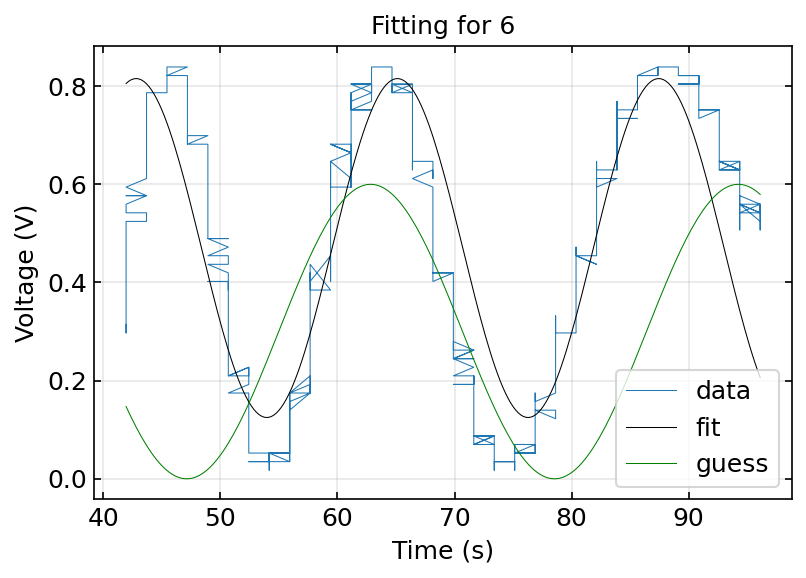

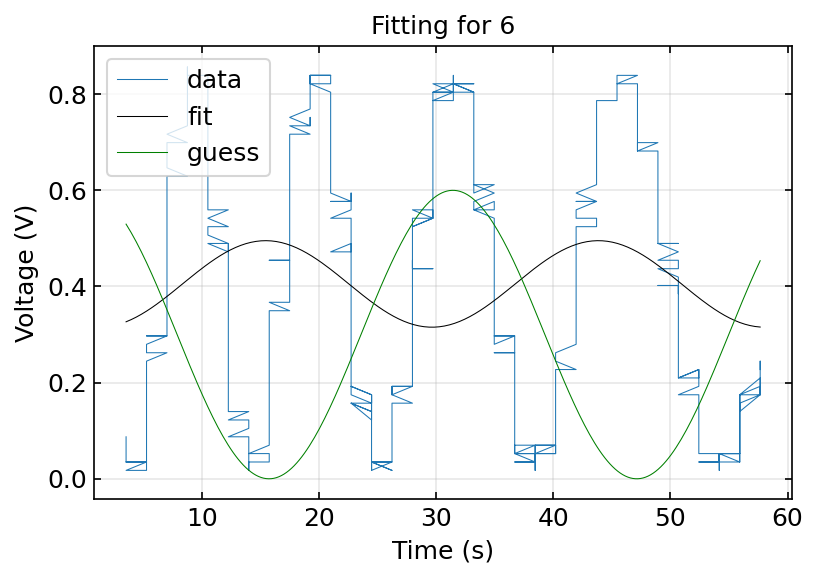

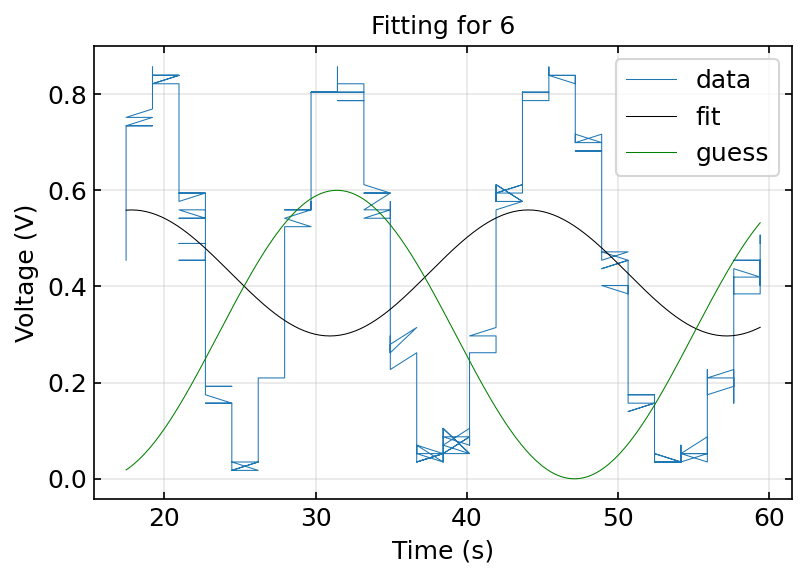

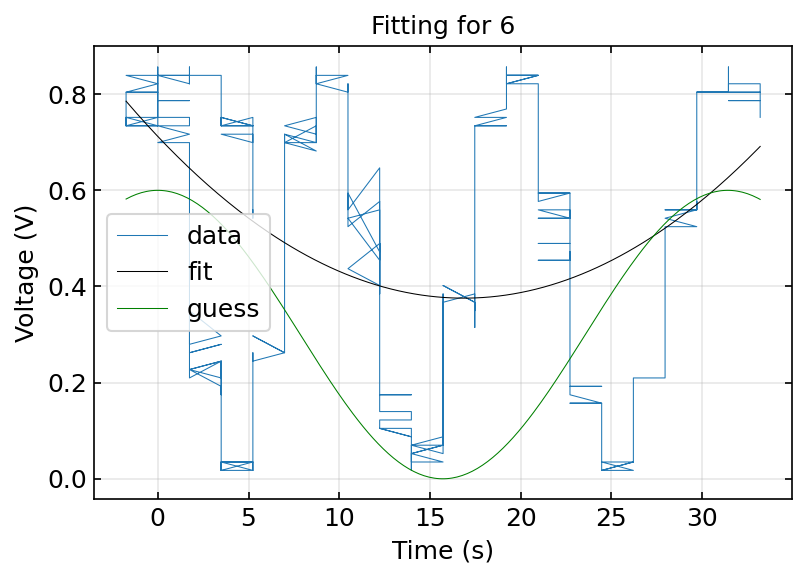

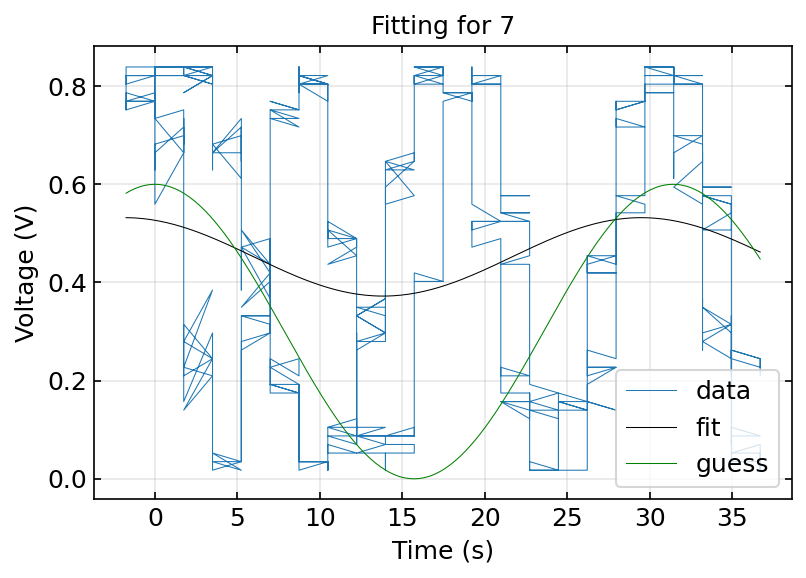

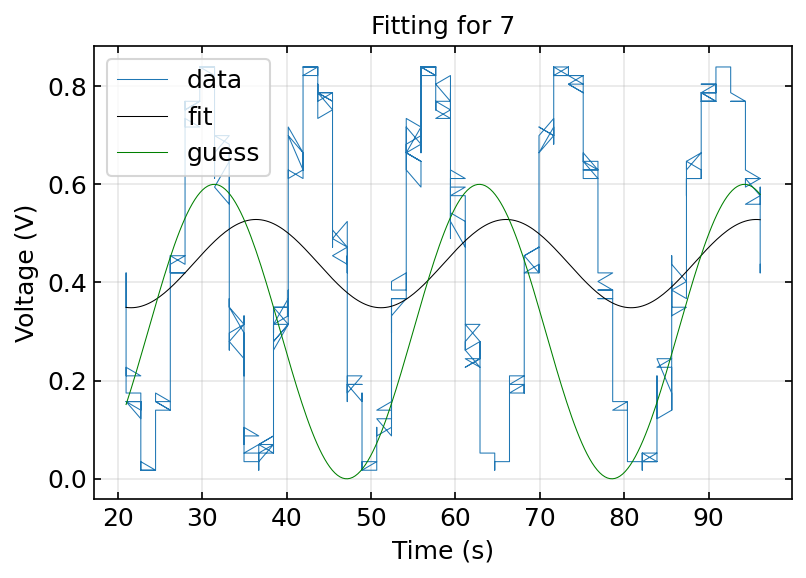

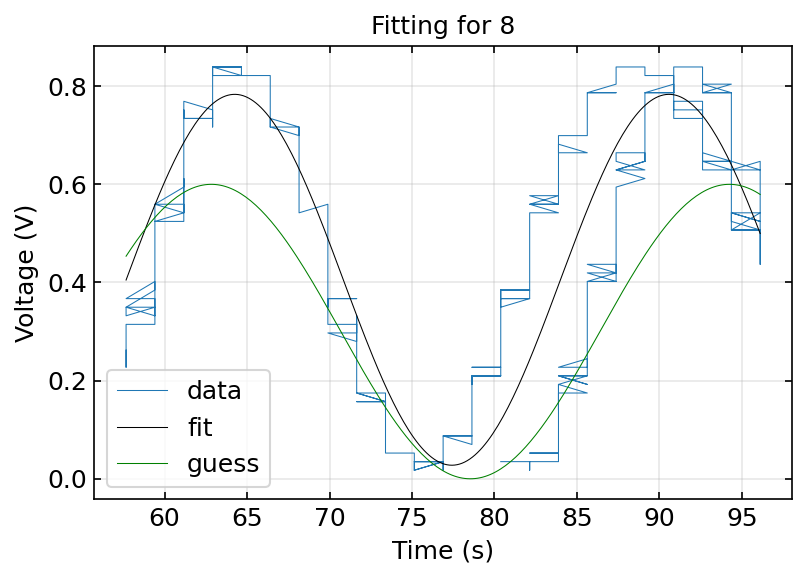

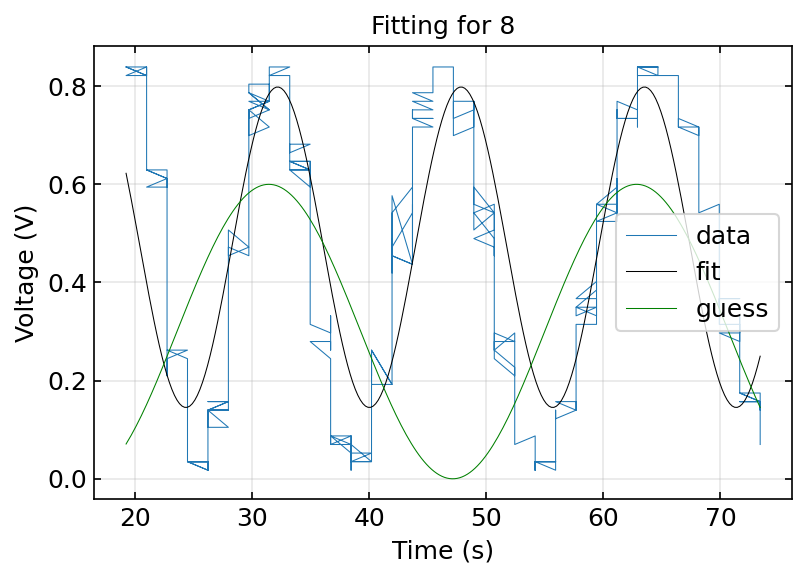

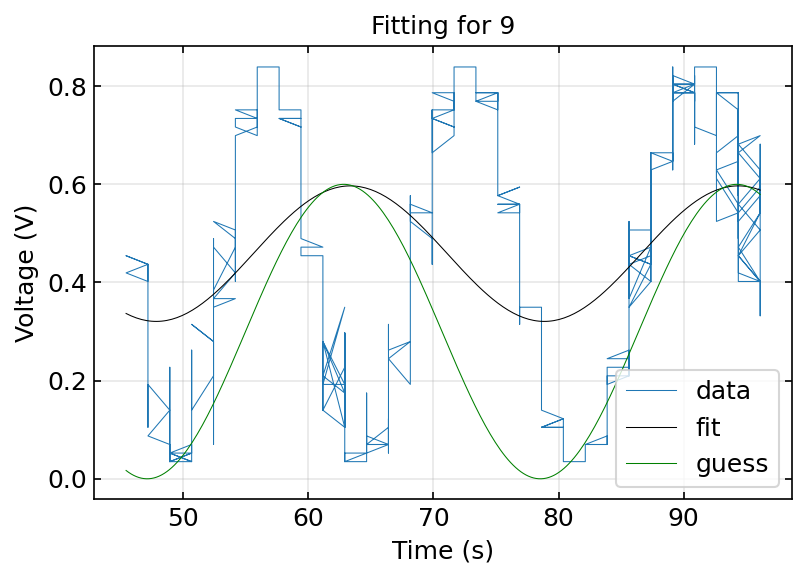

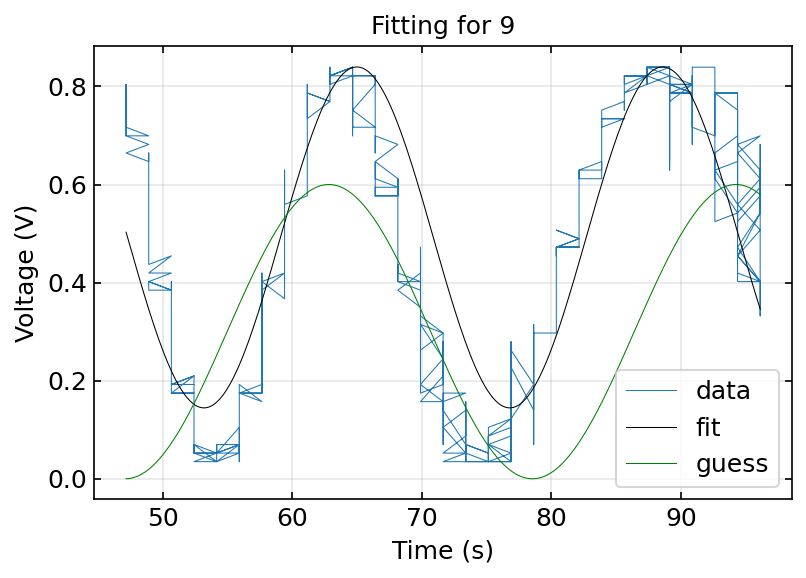

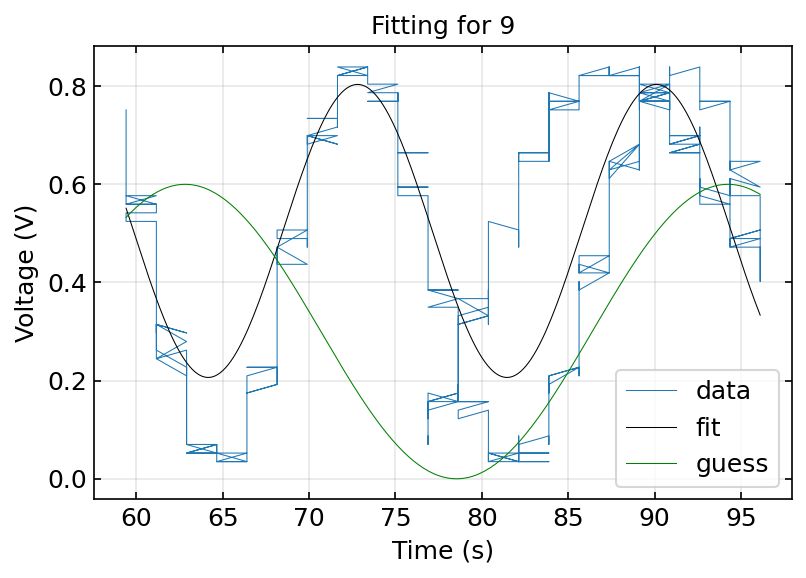

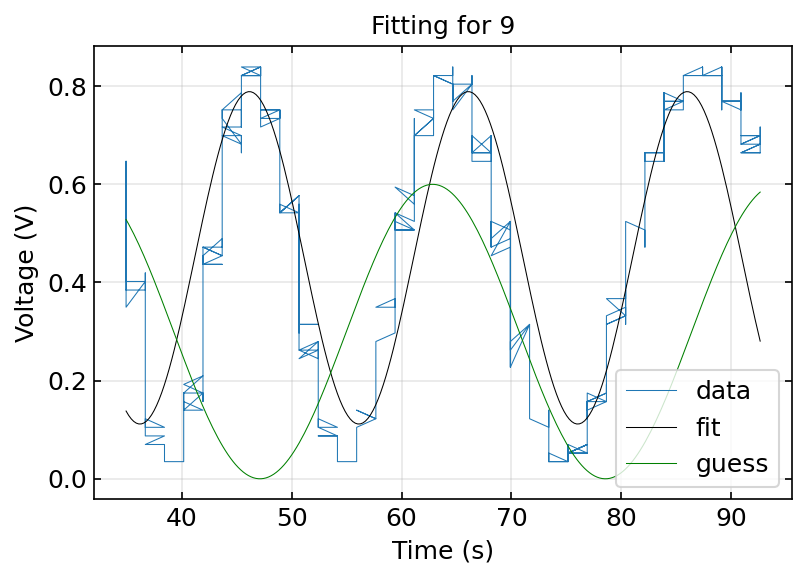

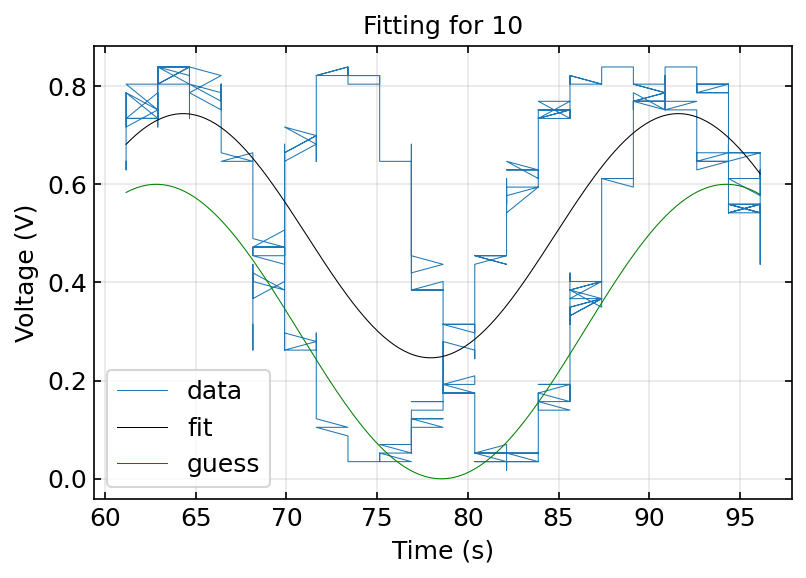

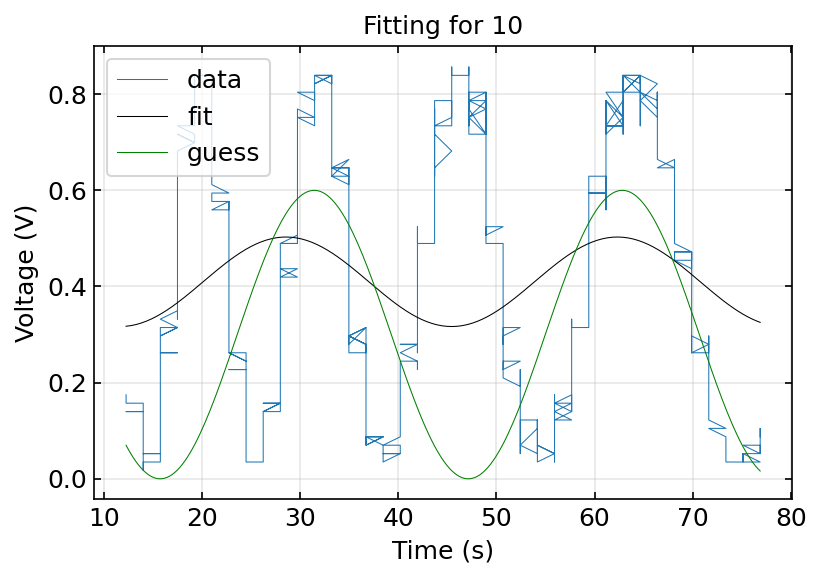

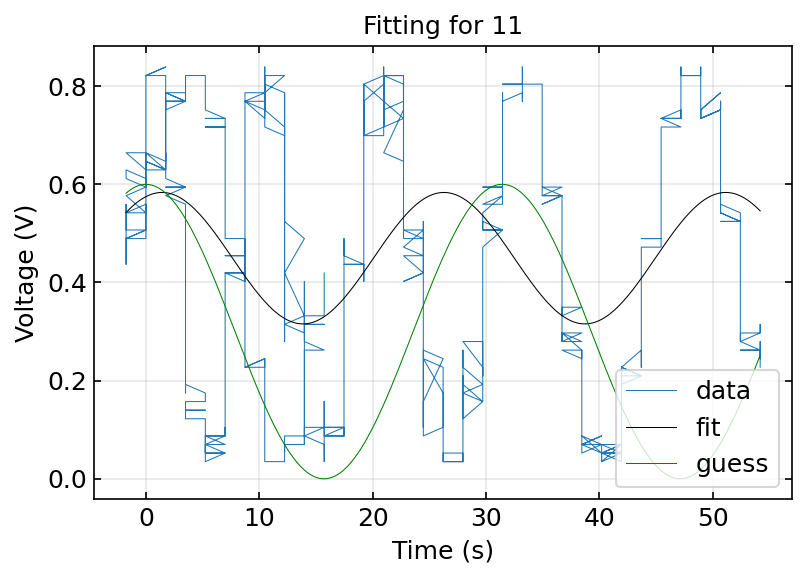

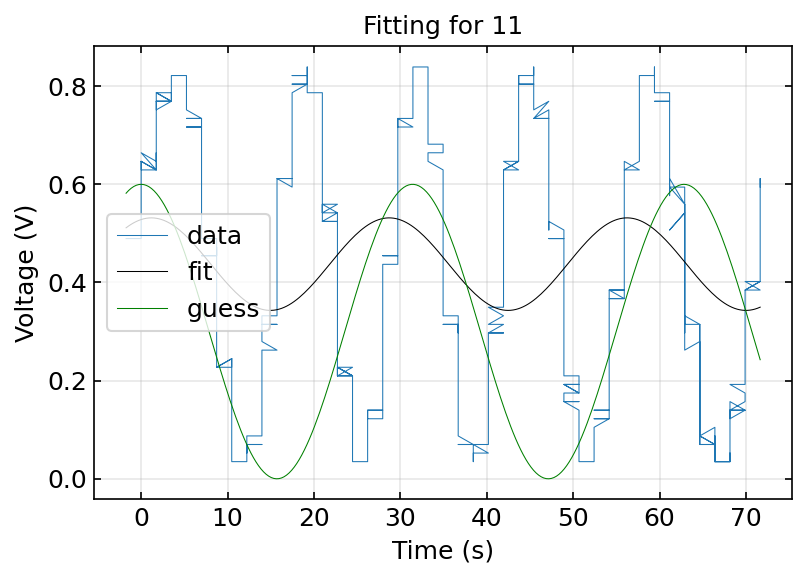

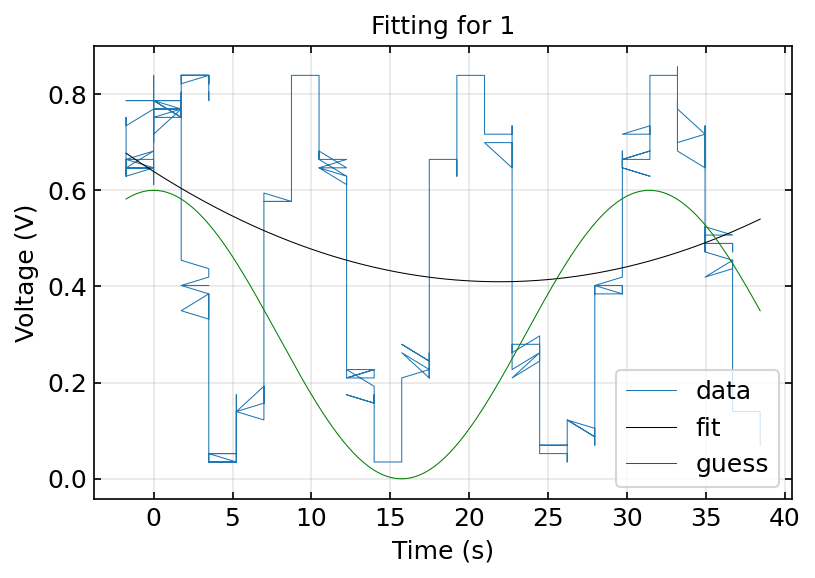

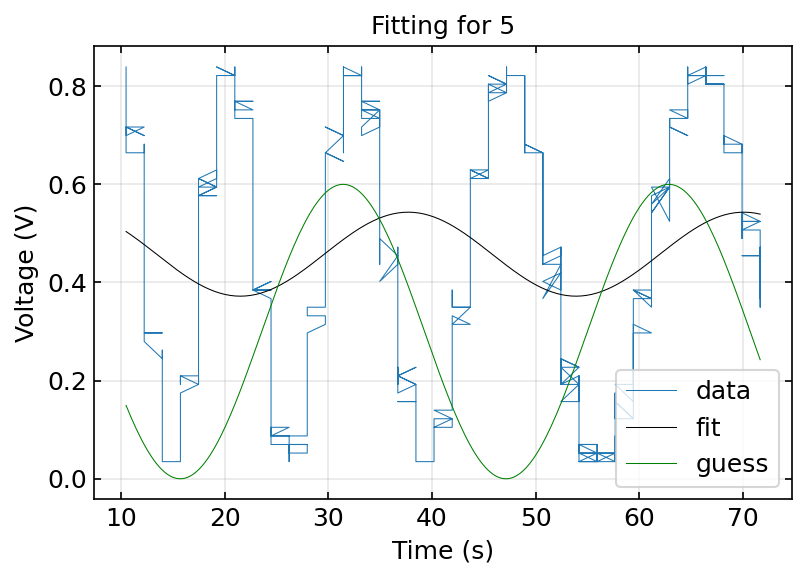

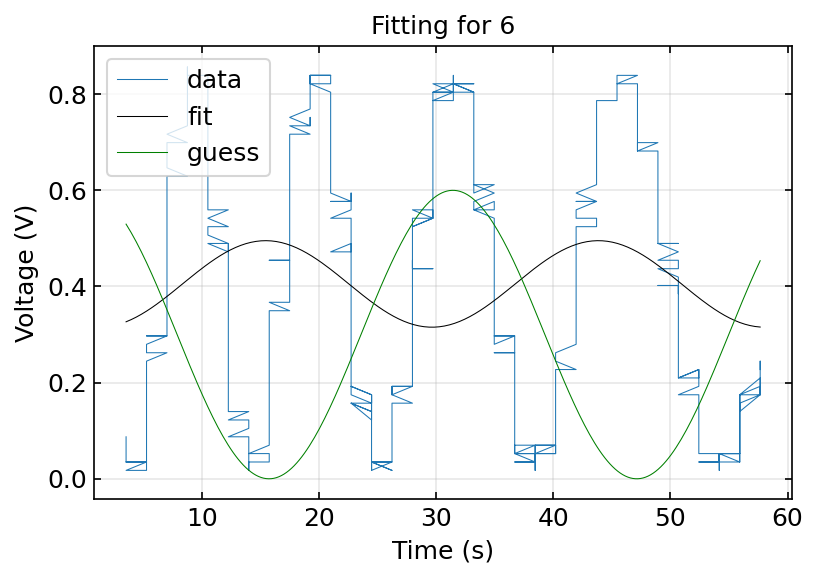

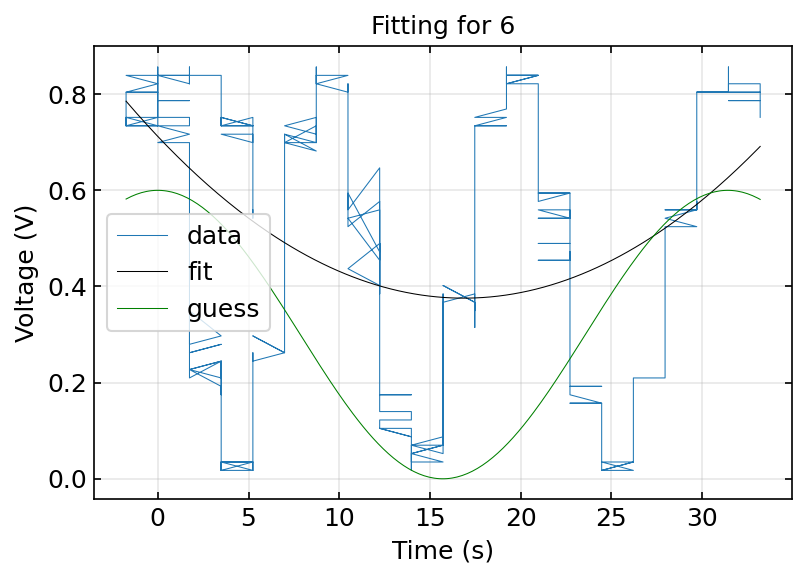

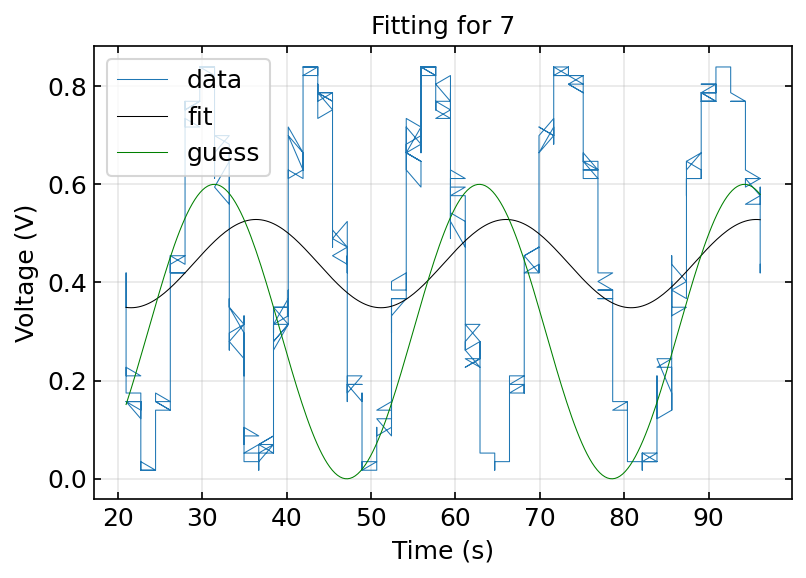

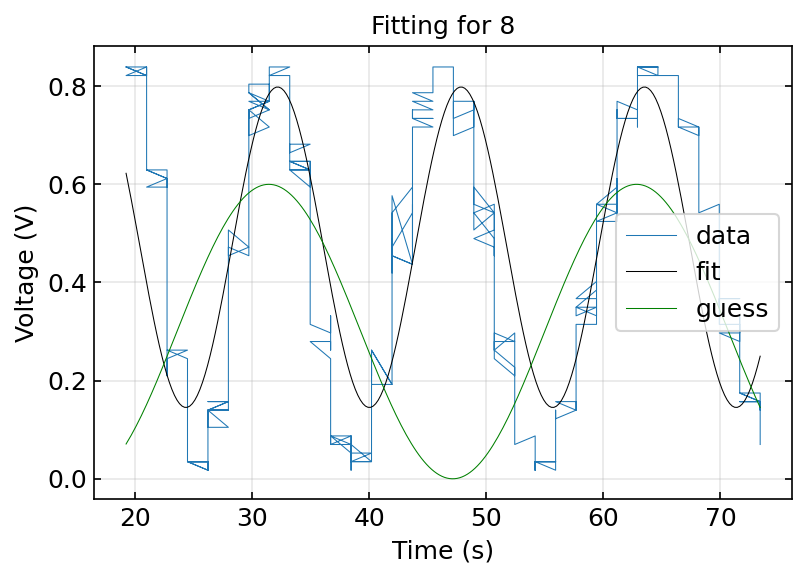

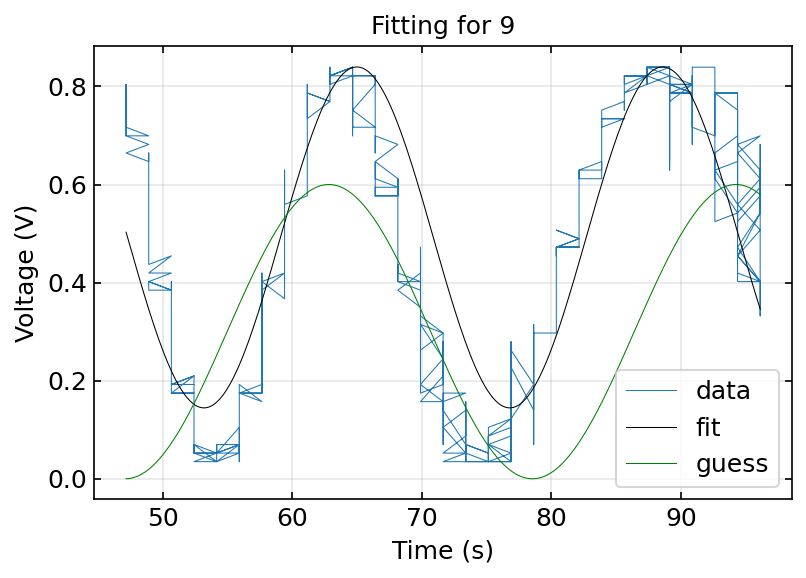

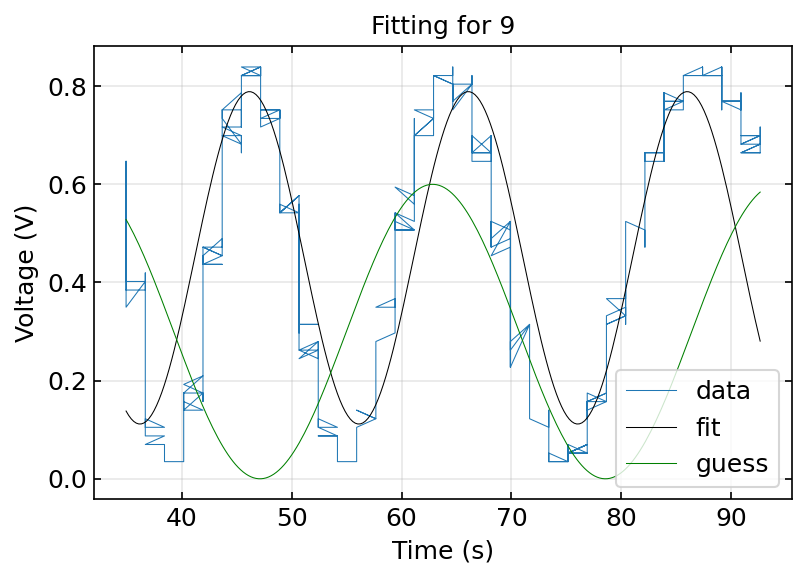

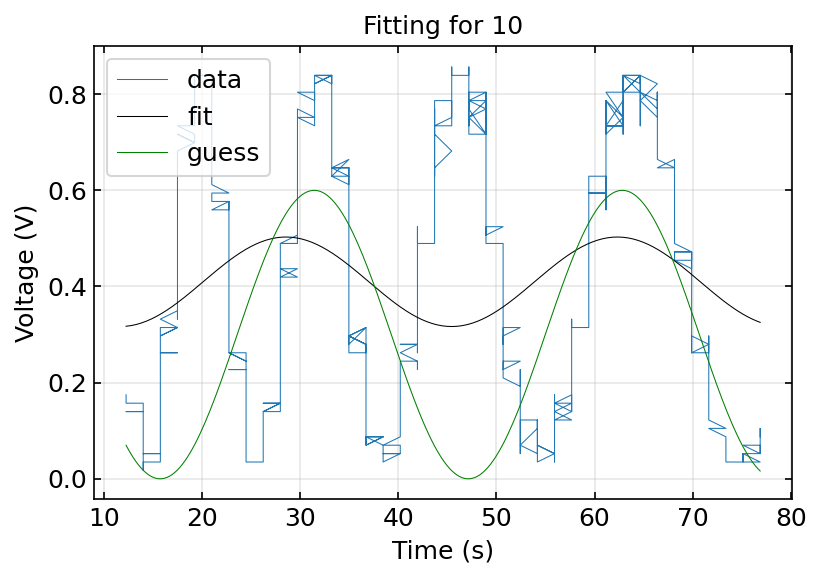

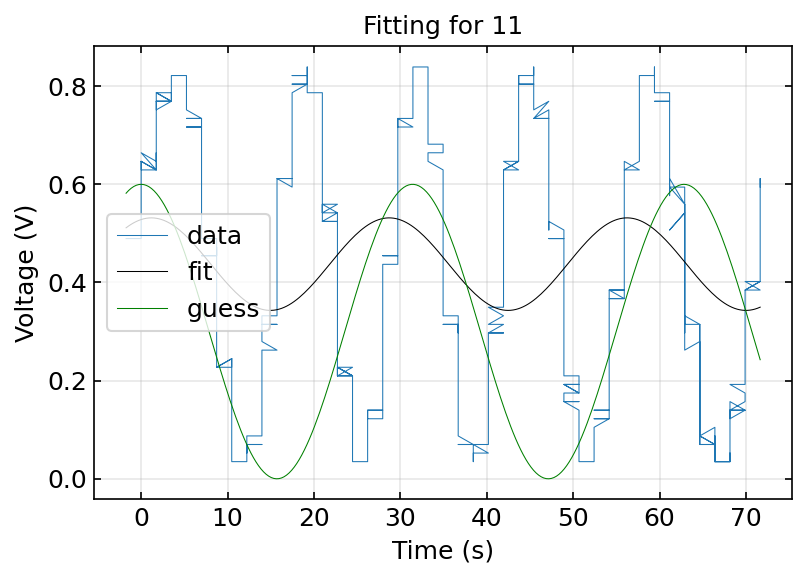

0 :
[0.13133450581763237, 363.32926127649233, 0.3043324896423817, 0.0855756171257531, 0.34533232120229557, -0.08999219133014863, -0.13106037477691393, 547.9935928871771, 0.079893780485736, 0.08990795639152353, 0.37786122944393746, 0.326553815235458, 0.13806903307356158, 0.3475753998732806, 0.2985465617675192, 0.3386909590045568, 0.24876638949634688, 0.0930953323908379, 0.1339220325882816, 0.09426922634496619, 363.32926127649233, 0.0855756171257531, -0.08999219133014863, 547.9935928871771, 0.08990795639152353, 0.326553815235458, 0.3475753998732806, 0.3386909590045568, 0.0930953323908379, 0.09426922634496619]

1 :
[0.2144585362756207, 0.0016209600298388905, 0.24113377022544866, 0.19408510098141157, 0.2814866523789049, 0.22109245327246804, 0.23940464442063467, 0.002077702141105521, 0.20071264625025143, 0.21197828382778167, 0.23860724033600958, 0.4009602616589131, 0.2026037110702808, 0.2663219743616142, 0.36332008000617905, 0.31561212447587, 0.23025365444887536, 0.18591215131767488, 0.2527

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display

labelsize = 12 # Labelsize should be 7 in the end

# Universal layout for figures. Can be changed for the specific graph.
# plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
# plt.rc("text", usetex = False) # Not sure, what this does
plt.rc('axes', labelsize = labelsize, titlesize = labelsize) 
plt.rc('xtick', labelsize = labelsize, top = True, direction = 'in')
plt.rc('ytick', labelsize = labelsize, right = True, direction = 'in')
plt.rc('legend', fontsize = labelsize)
plt.rc('lines', linewidth = 0.5)
cm = 1/2.54
capsize = 1.2
alpha = 0.3

wavelength = 632.8 *10**-9 # wavelength of He-Ne laser

def theoretical_intensity(x, *p): # Defining theoreticla model
    A = p[0]
    w = p[1]
    n = p[2]
    c = p[3]
    I = A*np.cos(w * x + n) + c
    return I

A_guess = 0.3 # Defining guesses
w_guess = 0.2
n_guess = 0
c_guess = 0.3

p_init = [A_guess, w_guess, n_guess, c_guess]


files = [] # Preparing for importing data
times = []
channel_A = []
channel_B = []

print('Importing data')

#for i in range(11): # Importing data - range 11
 #   j = i + 1
#    path = fr'c:\Users\jakob\Desktop\Eksperimentiel fysik 2\Øvelse 2\Michelson interferometer filer\Michelson interferometer filer_{j}.txt'
 #   file = np.genfromtxt(path, delimiter = '\t', skip_header = 2)
 #   files.append(file)
    
 #   time = file[:, 0]
  #  A = file[:, 1]
   # B = file[:, 2]
   # times.append(time)
   # channel_A.append(A)
   # channel_B.append(B)
Data_names = []
for (dir_path, dir_names, file_names) in os.walk('./Labday_2_measurements_2'):
    Data_names.extend(file_names)
Data_list = []

for i, Data_name in enumerate(Data_names):
    Data = np.loadtxt('Labday_2_measurements_2/' + Data_name, skiprows = 3)
    Data_list.append(Data)

for data in Data_list:
    time =data[:,0]
    A = data[:, 1]  # Assuming V1 is the second column
    B = data[:, 2]  # Assuming V2 is the third column
    times.append(time)
    channel_A.append(A)
    channel_B.append(B)

    


print('Data succesfully imported') # Informing the user, that the data has succesfully imported

def figure(time, A, B): # Defining how to plot the raw data
    fig, ax = plt.subplots()
    ax.plot(time, A, color = 'tab:blue', label = 'data')
    ax.plot(time, B, color = 'green', label = 'Frequency generator')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')
    ax.legend()

figures = [] # Potentially plotting the raw data
for time, A, B in zip(times, channel_A, channel_B):
    figures.append(figure(time, A, B))

plt.show()

def fitting(file_number, lower_limit, upper_limit, guess = p_init): # Defineing how fitting in a certain interval is done 
    mask = [t >= lower_limit and t <= upper_limit for t in times[file_number]]
    time = times[file_number][mask]
    A = channel_A[file_number][mask]
    B = 10*channel_B[file_number][mask]

    N = 250

    xs = np.linspace(min(B), max(B), N)
    ys_guess = theoretical_intensity(xs, *guess)
    p_opt, p_cov = curve_fit(theoretical_intensity, B, A, p0 = guess)

    ys_fit = theoretical_intensity(xs, *p_opt)

    fig, ax = plt.subplots()
    ax.plot(B, A, label = 'data', color = 'tab:blue')
    ax.plot(xs, ys_fit, label = 'fit', color = 'k')
    ax.plot(xs, ys_guess, label = 'guess', color = 'g')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title(f'Fitting for {file_number + 1}')
    ax.legend()
    ax.grid(alpha = alpha)

    return p_opt, p_cov


ps_opt = [[], [], [], []] # Preparing for fitting
ps_cov = []
ps_cov2 = [[], [], [], []]


# Finding the files and time stamps that can be used

# file_numbers = [1, 2, 5, 6, 6, 7, 8, 9, 9, 10, 11] # List of good files with their respective intervals
#                                                     # 2nd 6 can be removed - 1st 6 is rather bad. maybe use another guess
# lower_limits = [1.8, 4.2, 4.5, 0, 5.8, 6.4, 5.5, 0.8, 6, 3.2, 4]
# upper_limits = [3.7, 6.5, 7.2, 2.3, 7.5, 9.8, 7.8, 3.3, 8.5, 6, 7.2]

# file_numbers = [1, 2, 5, 6, 7, 8, 9, 9, 10, 11] # List of good files with their respective intervals
#                                                     # 2nd 6 can be removed - 1st 6 is rather bad. maybe use another guess
# lower_limits = [1.8, 4.2, 4.5, 5.8, 6.4, 5.5, 0.8, 6, 3.2, 4]
# upper_limits = [3.7, 6.5, 7.2, 7.5, 9.8, 7.8, 3.3, 8.5, 6, 7.2]

true_file_numbers = [1, 5, 6, 6, 7, 8, 9, 9, 10, 11] # List of good files with their respective intervals
                                                    # 2nd 6 can be removed - 1st 6 is rather bad. maybe use another guess
true_lower_limits = [1.8, 4.5, 0, 5.8, 6.4, 5.5, 0.8, 6, 3.2, 4]
true_upper_limits = [3.7, 7.2, 2.3, 7.5, 9.8, 7.8, 3.3, 8.5, 6, 7.2]
file_numbers = []
lower_limits = []
upper_limits = []
for i in range(len(true_file_numbers)):
    file_numbers += [true_file_numbers[i], true_file_numbers[i]]
    lower_limits += [true_lower_limits[i], (true_lower_limits[i] + true_upper_limits[i])/2 - 0.2]
    upper_limits += [(true_lower_limits[i] + true_upper_limits[i])/2 + 0.2, true_upper_limits[i] ]
    
for i in range(len(true_file_numbers)):
    file_numbers += [true_file_numbers[i]]
    lower_limits += [(true_lower_limits[i] + true_upper_limits[i])/2 - 0.2]
    upper_limits += [true_upper_limits[i] ]

print('Fitting begins')

for file, lim_1, lim_2 in zip(file_numbers, lower_limits, upper_limits): # Fitting
    i = file - 1
    p_opt, p_cov = fitting(i, lim_1, lim_2)
    for j in range(4):
        ps_opt[j].append(p_opt[j])
        ps_cov2[j].append(np.sqrt(p_cov[j][j]))
    ps_cov.append(p_cov)


print('Fitting was succesfull') # Informing the user that the fitting did not encounter any major issues.

plt.show() # Potentially plotting the fits

for i in range(3): # Potentially printing the raw fitting parameter's values
    print(i, ':')
    print(ps_opt[i])
    print('')



for i, A in enumerate(ps_opt[0]): # Cleaning up the fitting parameter, so the amplitudes are positive
    if A < 0:
        ps_opt[0][i] = -A # Correcting the amplitude
        ps_opt[2][i] += np.pi # Correcting the phase shift
    else:
        pass


if any([n > 2*np.pi for n in ps_opt[2]]): # Cleaning up the fitting parameter, so the phaseshifts are between -pi and pi
    m = max(max(np.array(ps_opt[2])/np.pi), abs(min(np.array(ps_opt[2])/np.pi))) # Times of necessary corrections
    print('Times of necessary corrections:', int(m))
    for _ in range(int(m)): 
        for i, n in enumerate(ps_opt[2]):
            if n > np.pi: # Correcting the phase if too high - Change this to upper limit if it is not pi (e.g. 2 pi) 
                ps_opt[2][i] -= 2*np.pi
            elif n < -np.pi: # Correcting the phase if too low - Change this to lower limit if it is not -pi (e.g. 0)
                ps_opt[2][i] += 2*np.pi
            else:
                pass
            

print('')
print('')


def average(parameter, err):
    w = 1/np.array(err)**2
    
    value = np.sum(np.array(parameter) * w)
    total_err = np.sum(w)
    
    mean = value/total_err
    error = 1/np.sqrt(np.sum(w))
    return mean, error


means = []
errors = []
for i in range(len(ps_opt)):
    print('Optimal parameter number:', i)
    mean, err = average(ps_opt[i], ps_cov2[i])
    print(np.round(ps_opt[i], 10))
    print('Mean:', mean)
    print('Uncertainty: ', err)
    print('')
    means.append(mean)
    errors.append(err)

c = wavelength/(2*np.pi)
print('Final value for expansion coefficient:', c * means[1])
print('Error of expansion coefficient: ', c * errors[1])
# Driving frequency around 5.69 Hz
# Driving voltage amplitude around 9.33 V